In [ ]:
# !mkdir -p ~/.kaggle

In [ ]:
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

In [ ]:
# !unzip  cell-images-for-detecting-malaria.zip

In [ ]:
import tensorflow as tf
# import keras

Using TensorFlow backend.


In [ ]:
from tensorflow.keras import  Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import os 
import glob

In [ ]:
base_dir = os.path.join('/content/cell_images/cell_images')
infected_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir  = os.path.join(base_dir, 'Uninfected')


In [ ]:
infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(uninfected_dir+'/*.png')

In [ ]:
len(healthy_files), len(infected_files)

(13779, 13779)

In [ ]:
import pandas as pd

In [ ]:
np.random.seed(42)

In [ ]:
dataframe = pd.DataFrame({
                          'file_name': infected_files+healthy_files,
                          'label': ['malaria']*len(infected_files) + ['healthy']*len(healthy_files)

}).sample(frac=1, random_state = 42).reset_index(drop=True)

In [ ]:
dataframe.head()

,file_name,label
0,/content/cell_images/cell_images/Parasitized/C...,malaria
1,/content/cell_images/cell_images/Parasitized/C...,malaria
2,/content/cell_images/cell_images/Uninfected/C8...,healthy
3,/content/cell_images/cell_images/Uninfected/C1...,healthy
4,/content/cell_images/cell_images/Uninfected/C1...,healthy


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
train_files, test_files, train_labels , test_labels = train_test_split(dataframe['file_name'].values,
                                                                     dataframe['label'].values,
                                                                     test_size = 0.3,random_state =42)

In [ ]:
train_files, val_files, train_labels , val_labels = train_test_split(train_files,
                                                                     train_labels,
                                                                     test_size = 0.1,random_state =42)

In [ ]:
print(train_files.shape, val_files.shape, test_files.shape)

(17361,) (1929,) (8268,)


In [ ]:
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))


Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [ ]:
import cv2
from concurrent import futures
import threading

In [ ]:
def get_img_shape(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_5: working on img num: 5000
ThreadPoolExecutor-0_1: working on img num: 10000
ThreadPoolExecutor-0_0: working on img num: 15000
ThreadPoolExecutor-0_3: working on img num: 17360
Min Dimensions: [40 46  3]
Avg Dimensions: [133.         132.51909452   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 394   3]


In [ ]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 5000
ThreadPoolExecutor-1_9: working on img num: 10000
ThreadPoolExecutor-1_2: working on img num: 15000
ThreadPoolExecutor-1_0: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_6: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_9: working on img num: 0
ThreadPoolExecutor-1_8: working on img num: 5000
ThreadPoolExecutor-1_0: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

In [ ]:
r = np.random.randint(0 , train_data.shape[0] , 1)

In [ ]:
train_data

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

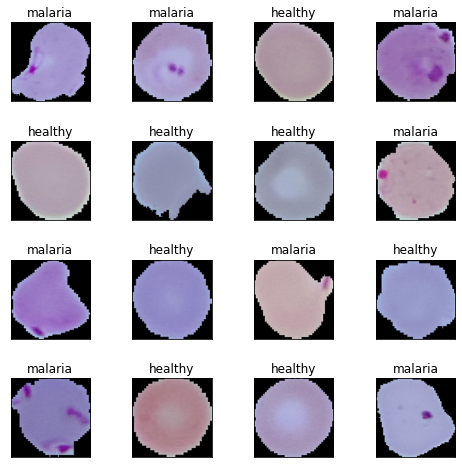

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [ ]:
#setting basic things

In [ ]:
batch_size = 64
n_classes = 2
input_shape = (125,125,3)
epochs = 25

train_img_scaled = train_data/255.
val_img_scaled = val_data/255.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_label_enc = le.fit_transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:5], train_label_enc[:5])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy'] [1 1 1 0 0]


In [ ]:
test_label_enc = le.transform(test_labels)

In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
inp = tf.keras.layers.Input(shape=input_shape)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [ ]:
#Train model

In [ ]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_detection_one.h5", save_best_only=True)
callbacks = [reduce_lr,early_stopping_cb,model_checkpoint_cb]

history = model.fit(x=train_img_scaled, y=train_label_enc, 
                    batch_size=batch_size,
                    epochs=100, 
                    validation_data=(val_img_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100
272/272 [==============================] - 22s 82ms/step - loss: 0.4142 - accuracy: 0.7875 - val_loss: 0.1695 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 2/100
272/272 [==============================] - 22s 80ms/step - loss: 0.1580 - accuracy: 0.9519 - val_loss: 0.1458 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 3/100
272/272 [==============================] - 22s 80ms/step - loss: 0.1404 - accuracy: 0.9553 - val_loss: 0.1451 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 4/100
272/272 [==============================] - 21s 78ms/step - loss: 0.1230 - accuracy: 0.9595 - val_loss: 0.1516 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 5/100
272/272 [==============================] - 21s 78ms/step - loss: 0.1084 - accuracy: 0.9622 - val_loss: 0.1506 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 6/100
272/272 [==============================] - 21s 78ms/step - loss: 0.0806 - accuracy: 0.9722 - val_loss: 0.1572 - val_accuracy: 0.9539 - lr: 5.0000e-04
Epoch 7/100
272/272 [===========================

In [ ]:
#tarnsfer learning

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)


In [ ]:
train_data_gen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255., zoom_range=0.05,
                                                                  rotation_range=25,
                                                                  width_shift_range = 0.05,
                                                                  height_shift_range= 0.05,
                                                                  shear_range = 0.05,
                                                                  horizontal_flip=True,
                                                                  fill_mode= 'nearest')
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_data_gen.flow(train_data, train_label_enc, batch_size=batch_size, shuffle=True)
val_gen =  val_data_gen.flow(val_data, val_labels_enc, batch_size=batch_size, shuffle=False)

In [ ]:
# Freeze the layers
vgg.trainable = True
set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0     

In [ ]:

base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])


In [ ]:



reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_detection_one_vgg.h5", save_best_only=True)
callbacks = [reduce_lr,early_stopping_cb,model_checkpoint_cb]


train_steps_per_epoch = train_gen.n // train_gen.batch_size
val_steps_per_epoch = val_gen.n // val_gen.batch_size
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=40,
                              validation_data=val_gen, validation_steps=val_steps_per_epoch, 
                              verbose=1, callbacks= callbacks)

Epoch 1/40
271/271 [==============================] - 107s 395ms/step - loss: 0.2268 - accuracy: 0.9118 - val_loss: 0.1721 - val_accuracy: 0.9417 - lr: 1.0000e-05
Epoch 2/40
271/271 [==============================] - 107s 396ms/step - loss: 0.1379 - accuracy: 0.9531 - val_loss: 0.1450 - val_accuracy: 0.9510 - lr: 1.0000e-05
Epoch 3/40
271/271 [==============================] - 108s 398ms/step - loss: 0.1242 - accuracy: 0.9594 - val_loss: 0.1274 - val_accuracy: 0.9583 - lr: 1.0000e-05
Epoch 4/40
271/271 [==============================] - 107s 394ms/step - loss: 0.1193 - accuracy: 0.9588 - val_loss: 0.1400 - val_accuracy: 0.9594 - lr: 1.0000e-05
Epoch 5/40
271/271 [==============================] - 107s 396ms/step - loss: 0.1097 - accuracy: 0.9626 - val_loss: 0.1180 - val_accuracy: 0.9589 - lr: 1.0000e-05
Epoch 6/40
271/271 [==============================] - 108s 397ms/step - loss: 0.1081 - accuracy: 0.9636 - val_loss: 0.1104 - val_accuracy: 0.9656 - lr: 1.0000e-05
Epoch 7/40
271/271 [==

In [ ]:
#evaluate

In [ ]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [ ]:
basic_cnn = tf.keras.models.load_model('/content/malaria_detection_one.h5')

vgg_ft = tf.keras.models.load_model('/content/malaria_detection_one_vgg.h5')

In [ ]:
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

In [ ]:
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [ ]:
pred = [1 if pred > 0.5 else 0 
            for pred in vgg_ft_preds.ravel()]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(test_label_enc,pred )

0.965166908563135